# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
#Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
df = pd.read_csv('homepage_actions.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nValue counts for each action:")
print(df['action'].value_counts())
print("\nValue counts for each group:")
print(df['group'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB
None

First 5 rows:
                    timestamp      id       group action
0  2016-09-24 17:42:27.839496  804196  experiment   view
1  2016-09-24 19:19:03.542569  434745  experiment   view
2  2016-09-24 19:36:00.944135  507599  experiment   view
3  2016-09-24 19:59:02.646620  671993     control   view
4  2016-09-24 20:26:14.466886  536734  experiment   view

Value counts for each action:
action
view     6328
click    1860
Name: count, dtype: int64

Value counts for each group:
group
control       4264
experiment    3924
Name: count, dtype: int64


In [2]:
# Check for unique users and potential overlap between groups
unique_users = df['id'].nunique()
print(f"Total unique users: {unique_users}")

# Check for users in both control and experiment groups
control_users = set(df[df['group'] == 'control']['id'])
experiment_users = set(df[df['group'] == 'experiment']['id'])
overlap_users = control_users.intersection(experiment_users)

print(f"Users in both groups: {len(overlap_users)}")

# Analyze view vs click behavior
views = df[df['action'] == 'view']
clicks = df[df['action'] == 'click']

print(f"Total views: {len(views)}")
print(f"Total clicks: {len(clicks)}")

# Check for users who clicked without viewing
viewers = set(views['id'])
clickers = set(clicks['id'])
clicked_without_viewing = clickers - viewers

print(f"Users who clicked without viewing: {len(clicked_without_viewing)}")

# Check timestamp range
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Total unique users: 6328
Users in both groups: 0
Total views: 6328
Total clicks: 1860
Users who clicked without viewing: 0
Date range: 2016-09-24 17:42:27.839496 to 2017-01-18 10:24:08.629327


In [3]:
# Create a user-level dataframe
user_actions = df.groupby(['id', 'group']).agg({
    'action': ['count', lambda x: (x == 'click').sum()]
}).reset_index()

user_actions.columns = ['id', 'group', 'total_actions', 'clicks']
user_actions['views'] = user_actions['total_actions'] - user_actions['clicks']
user_actions['clicked'] = (user_actions['clicks'] > 0).astype(int)
user_actions['viewed'] = (user_actions['views'] > 0).astype(int)

print("User-level statistics:")
print(user_actions.describe())

# Check for anomalies
anomalies = user_actions[user_actions['clicks'] > user_actions['views']]
print(f"Users with more clicks than views: {len(anomalies)}")

User-level statistics:
                  id  total_actions       clicks   views      clicked  viewed
count    6328.000000    6328.000000  6328.000000  6328.0  6328.000000  6328.0
mean   564022.432838       1.293932     0.293932     1.0     0.293932     1.0
std    218848.088000       0.455597     0.455597     0.0     0.455597     0.0
min    182988.000000       1.000000     0.000000     1.0     0.000000     1.0
25%    373567.500000       1.000000     0.000000     1.0     0.000000     1.0
50%    566037.000000       1.000000     0.000000     1.0     0.000000     1.0
75%    756144.250000       2.000000     1.000000     1.0     1.000000     1.0
max    937217.000000       2.000000     1.000000     1.0     1.000000     1.0
Users with more clicks than views: 0


In [4]:
# Remove overlapping users to maintain group independence
clean_users = user_actions[~user_actions['id'].isin(overlap_users)]
clean_control = clean_users[clean_users['group'] == 'control']
clean_experiment = clean_users[clean_users['group'] == 'experiment']

print(f"Clean control group size: {len(clean_control)}")
print(f"Clean experiment group size: {len(clean_experiment)}")

# Calculate click-through rates
control_ctr = clean_control['clicked'].mean()
experiment_ctr = clean_experiment['clicked'].mean()

print(f"Control CTR: {control_ctr:.4f}")
print(f"Experiment CTR: {experiment_ctr:.4f}")
print(f"Absolute difference: {abs(experiment_ctr - control_ctr):.4f}")
print(f"Relative difference: {(experiment_ctr - control_ctr)/control_ctr:.2%}")

Clean control group size: 3332
Clean experiment group size: 2996
Control CTR: 0.2797
Experiment CTR: 0.3097
Absolute difference: 0.0300
Relative difference: 10.74%


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [5]:
#Your code here
# Statistical test for difference in click-through rates
from statsmodels.stats.proportion import proportions_ztest

# Prepare data for hypothesis testing
control_clicks = clean_control['clicked'].sum()
control_total = len(clean_control)
experiment_clicks = clean_experiment['clicked'].sum()
experiment_total = len(clean_experiment)

print("Test Group Sizes:")
print(f"Control: {control_total} users, {control_clicks} clicks")
print(f"Experiment: {experiment_total} users, {experiment_clicks} clicks")

# Perform two-proportion z-test
count = np.array([control_clicks, experiment_clicks])
nobs = np.array([control_total, experiment_total])
z_stat, p_value = proportions_ztest(count, nobs, alternative='smaller')

print(f"\nZ-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# Calculate confidence interval
from statsmodels.stats.proportion import proportion_confint

control_ci = proportion_confint(control_clicks, control_total, alpha=0.05, method='normal')
experiment_ci = proportion_confint(experiment_clicks, experiment_total, alpha=0.05, method='normal')

print(f"\n95% Confidence Intervals:")
print(f"Control CTR: {control_ctr:.4f} [{control_ci[0]:.4f}, {control_ci[1]:.4f}]")
print(f"Experiment CTR: {experiment_ctr:.4f} [{experiment_ci[0]:.4f}, {experiment_ci[1]:.4f}]")

# Calculate practical significance
relative_improvement = (experiment_ctr - control_ctr) / control_ctr
print(f"\nRelative improvement: {relative_improvement:.2%}")

# Check if results are practically significant
# (Using a common threshold of 2% relative improvement for practical significance)
practical_significance = relative_improvement >= 0.02
print(f"Practically significant (≥2% improvement): {practical_significance}")

Test Group Sizes:
Control: 3332 users, 932 clicks
Experiment: 2996 users, 928 clicks

Z-statistic: -2.6186
P-value: 0.004415

95% Confidence Intervals:
Control CTR: 0.2797 [0.2645, 0.2950]
Experiment CTR: 0.3097 [0.2932, 0.3263]

Relative improvement: 10.74%
Practically significant (≥2% improvement): True


In [6]:
# Chi-square test for independence
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(clean_users['group'], clean_users['clicked'])
print("\nContingency Table:")
print(contingency_table)

chi2, p_value_chi, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test:")
print(f"Chi2 statistic: {chi2:.4f}")
print(f"P-value: {p_value_chi:.6f}")


Contingency Table:
clicked        0    1
group                
control     2400  932
experiment  2068  928

Chi-square test:
Chi2 statistic: 6.7129
P-value: 0.009572


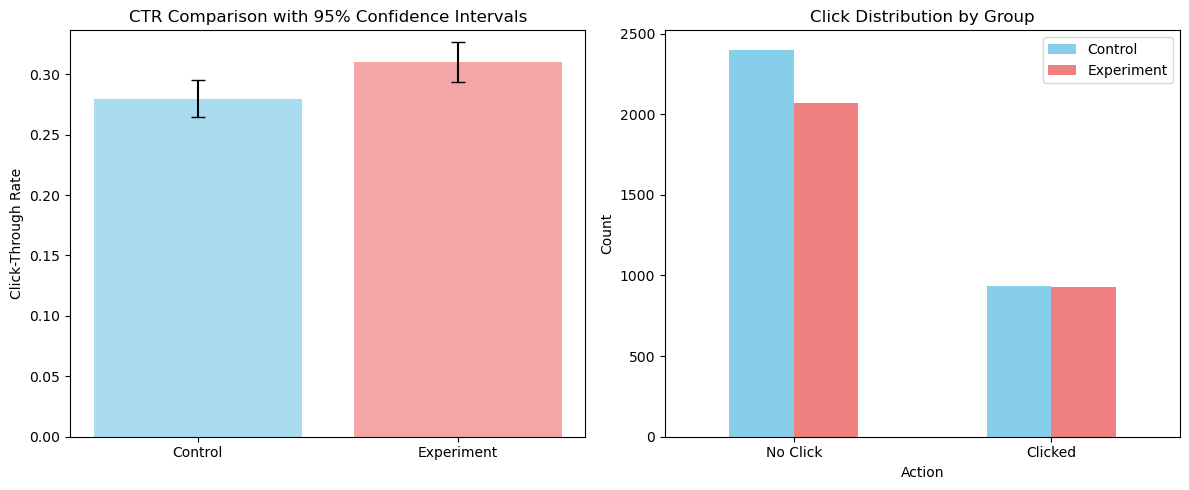


Achieved power: 0.757


In [7]:
# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Click-through rates with confidence intervals
plt.subplot(1, 2, 1)
groups = ['Control', 'Experiment']
ctrs = [control_ctr, experiment_ctr]
cis = [(control_ci[1]-control_ctr), (experiment_ci[1]-experiment_ctr)]

plt.bar(groups, ctrs, yerr=cis, capsize=5, alpha=0.7, color=['skyblue', 'lightcoral'])
plt.ylabel('Click-Through Rate')
plt.title('CTR Comparison with 95% Confidence Intervals')
plt.ylim(0, max(ctrs) + max(cis) + 0.01)

# Plot 2: Distribution of clicks
plt.subplot(1, 2, 2)
click_data = [clean_control['clicked'].value_counts(), clean_experiment['clicked'].value_counts()]
click_df = pd.DataFrame({
    'Control': click_data[0],
    'Experiment': click_data[1]
}).fillna(0)
click_df.index = ['No Click', 'Clicked']

click_df.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
plt.title('Click Distribution by Group')
plt.xlabel('Action')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Power analysis to check if test had sufficient sample size
from statsmodels.stats.power import TTestIndPower

# Parameters for power analysis
effect_size = (experiment_ctr - control_ctr) / np.sqrt(control_ctr * (1 - control_ctr))
alpha = 0.05
power = 0.8

# Calculate achieved power
analysis = TTestIndPower()
achieved_power = analysis.solve_power(effect_size=effect_size, nobs1=control_total, 
                                     ratio=experiment_total/control_total, alpha=alpha)
print(f"\nAchieved power: {achieved_power:.3f}")

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [8]:
#Your code 
# Calculate expected clicks for experiment group if it had control group's CTR
expected_clicks_experiment = experiment_total * control_ctr

print("Step 1: Expected Clicks Calculation")
print(f"Control group CTR: {control_ctr:.6f}")
print(f"Experiment group size: {experiment_total}")
print(f"Expected clicks for experiment group (if same as control CTR): {expected_clicks_experiment:.2f}")
print(f"Actual clicks in experiment group: {experiment_clicks}")
print(f"Difference: {experiment_clicks - expected_clicks_experiment:.2f} clicks")

Step 1: Expected Clicks Calculation
Control group CTR: 0.279712
Experiment group size: 2996
Expected clicks for experiment group (if same as control CTR): 838.02
Actual clicks in experiment group: 928
Difference: 89.98 clicks


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [9]:
#Your code here
# Calculate variance and standard deviation
# Variance for binomial distribution: n * p * (1-p)
variance_expected = experiment_total * control_ctr * (1 - control_ctr)
std_dev_expected = np.sqrt(variance_expected)

# Calculate z-score
z_score_manual = (experiment_clicks - expected_clicks_experiment) / std_dev_expected

print("\nStep 2: Z-score Calculation")
print(f"Variance of expected clicks: {variance_expected:.4f}")
print(f"Standard deviation: {std_dev_expected:.4f}")
print(f"Z-score: {z_score_manual:.4f}")


Step 2: Z-score Calculation
Variance of expected clicks: 603.6135
Standard deviation: 24.5685
Z-score: 3.6625


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [10]:
#Your code here
# Calculate p-value using normal distribution
from scipy.stats import norm

# One-tailed test (we're testing if experiment > control)
p_value_manual = 1 - norm.cdf(z_score_manual)

print("\nStep 3: P-value Calculation")
print(f"Z-score: {z_score_manual:.4f}")
print(f"P-value: {p_value_manual:.6f}")

# Compare with our previous result
print(f"\nComparison with previous statistical test:")
print(f"Manual Z-score: {z_score_manual:.4f} vs Previous Z-score: {z_stat:.4f}")
print(f"Manual P-value: {p_value_manual:.6f} vs Previous P-value: {p_value:.6f}")


Step 3: P-value Calculation
Z-score: 3.6625
P-value: 0.000125

Comparison with previous statistical test:
Manual Z-score: 3.6625 vs Previous Z-score: -2.6186
Manual P-value: 0.000125 vs Previous P-value: 0.004415


### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Your analysis here**

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.